In [20]:
path = r'C:/Users/ruw/Desktop'
import sys # https://stackoverflow.com/questions/4383571/importing-files-from-different-folder
sys.path.insert(1, rf'{path}\RA\penicilin\Libaries')



In [21]:
matching_database = "ev391cutoff"
database = "penicillin_cut_off"

In [22]:
import reload_lib as rl
# import lca
import standards as s
import sensitivity as st
import brightway2 as bw 

import bw2data as bd
import bw2calc as bc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import standards as s
import database_manipulation as dm


In [23]:
from lca import LCA

var = LCA(path=path, matching_database=matching_database)


In [24]:
ics = var.lcia_impact_method()
ics[1]

('ReCiPe 2016 v1.03, midpoint (H) - no biogenic',
 'climate change',
 'global warming potential (GWP1000)')

In [139]:
def extract_penG_electricity(sub, lst, val):
    val *= sub['amount']
    elec1 = val
    elec2 = val
    elec_val = {}
    for sub2x in sub.input.exchanges():
        if "electricity" in sub2x['name']:
            elec1 *= sub2x['amount']
            elec_val["prod 1"] = elec1
        elif "penicil" in sub2x['name']:
            lst.append({sub2x.input : sub2x['amount']})
            elec2 *= sub2x['amount']
            for sub3x in sub2x.input.exchanges():
                if "electricity" in sub3x['name']:
                    elec2 *=  sub3x['amount']
                    key = sub3x.input
                    elec_val["prod 2"] = elec2
    lst.append({key : elec1 + elec2})

    return elec_val

def extract_penG_activities(val, exc, lst):
    for sub in exc.input.exchanges():
        # print(sub)
        if "transport" in sub['name']:
            lst.append({sub.input : val*sub['amount']})
        elif  "filling" in sub['name']:
            elec_val = extract_penG_electricity(sub, lst, val)
    return elec_val

def extract_penV_activities(lst, val, exc):
    elec_val = {}
    for sub in exc.input.exchanges():
        if 'transport' in sub['name']:
            lst.append({sub.input : val*sub['amount']})
        elif "production" in sub['name']:
            val *= sub['amount']
            for sub2x in sub.input.exchanges():
                
                elec1 = val
                elec2 = val
                elec3 = val
                for sub2x in sub.input.exchanges():
                    if "electricity" in sub2x['name']:
                        elec1 *= sub2x['amount']
                        elec_val["prod 1"] = elec1
                    elif "tablet" in sub2x['name']:
                        elec2 *= sub2x['amount']
                        elec3 *= sub2x['amount']
                        for sub3x in sub2x.input.exchanges():
                            if "electricity" in sub3x['name']:
                                elec2 *=  sub3x['amount']
                                elec_val["prod 2"] = elec2
                            elif "penicil" in sub3x['name']:
                                if {sub3x.input : sub3x['amount']} not in lst:
                                    lst.append({sub3x.input : sub3x['amount']})
                                elec3 *= sub3x['amount']
                                for sub4x in sub3x.input.exchanges():
                                    if "electricity" in sub4x['name']:
                                        elec3 *=  sub4x['amount']
                                        key = sub4x.input
                                        elec_val["prod 3"] = elec3
            lst.append({key : elec1 + elec2 + elec3})
    return elec_val
            

In [37]:
system_path = var.system_path
dm.import_databases(sensitivty=True)
sheets_to_import = dm.extract_excel_sheets()


In [140]:
pen_type =  ["G", "V"]
func_unit = {}
db = var.db
for pt in pen_type:
        temp_lst = []
        for act in db:
            if f"Penicillin {pt}" in act['name']:
                  func_unit[act['name']] = {}

In [ ]:
# Check if the database is case1
for sheet in sheets_to_import:
    data = pd.read_excel(system_path, sheet_name=sheet)
    db_name = data.columns[1]
    db = bd.Database(db_name)
    
    for pt in pen_type:
        temp_lst = []
        for act in db:
            
            if f"Penicillin {pt}" in act['name']:
                for exc in act.exchanges():
                    if exc['type'] == 'technosphere':
                        val = exc['amount']
                        temp_lst.append({exc.input : exc['amount']})
                        if "packaging of glass vials with penicillin G" in exc.input['name']:
                            elec_val_G = extract_penG_activities(val, exc, temp_lst)
                        elif "medicine strip" in exc.input['name']:
                           elec_val_V = extract_penV_activities(temp_lst, val, exc)
                    func_unit[act['name']].update({db_name : temp_lst})
                


In [ ]:
# Initialize DataFrame to store results
df_dct = {}

for pen, fu_dct in func_unit.items():
    # print(pen)
    pen_arr = []
    for country, fu in fu_dct.items():
        print(f"Performing LCIA for {pen} - {country}")
        idx_lst = []
        for dct in fu:
            idx_lst.append(list(dct.keys())[0])
        idx_lst.sort
        df = pd.DataFrame(0, index=idx_lst, columns=[ics[1]], dtype=object)
        
        # Set up and perform the LCA calculation
        bd.calculation_setups[str(country)] = {'inv': fu, 'ia': [ics[1]]}
            
        mylca = bc.MultiLCA(str(country))
        res = mylca.results
        pen_arr.append(res)


    df_dct[pen] = pen_arr
    


Performing LCIA for Penicillin G, defined system - penicillin_cut_off_IN
Performing LCIA for Penicillin G, defined system - penicillin_cut_off_CN
Performing LCIA for Penicillin G, defined system - penicillin_cut_off_IT
Performing LCIA for Penicillin G, defined system - penicillin_cut_off_CH
Performing LCIA for Penicillin G, defined system - penicillin_cut_off_US
Performing LCIA for Penicillin G, defined system - penicillin_cut_off_DK
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_IN
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_CN
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_IT
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_CH
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_US
Performing LCIA for Penicillin V, defined system - penicillin_cut_off_DK


In [155]:
tot_elec_V = 0
tot_elec_G = 0

for val in elec_val_V.values():
    tot_elec_V += val

for val in elec_val_G.values():
    tot_elec_G += val


penV_prod_share = elec_val_V["prod 3"]/tot_elec_V
penG_prod_share = elec_val_G["prod 2"]/tot_elec_G
penG_prod_share

0.29675193158802793

In [183]:
impact_dct = {pen: None for pen in func_unit.keys()}
for pen, fu in func_unit.items():
    impact_dct[pen] = {}
    for lst_idx, (country, lst) in enumerate(fu.items()):
        for val_idx, act in enumerate(lst):
            val = df_dct[pen][lst_idx][val_idx]
            act_key = list(act.keys())[0]
            if country not in impact_dct[pen]:
                impact_dct[pen][country] = {}
            impact_dct[pen][country][str(act_key)] = val[0]


G = "'packaging of glass vials with penicillin G'"
V = "'packaging of a medicine strip'"

lst_GV = [G, V]

for pen, res_dct in impact_dct.items():
    for country, val_dct in res_dct.items():
        for key, val in val_dct.items():
            if "electricity" in str(key) and "V" in pen:
                proc = f"'manufacturing of raw penicillium V' (kilogram, {country[-2:]}, None)"
                pen_impact = val_dct[proc] 
                val_dct[proc] = pen_impact-(val*penV_prod_share)
                pen_impact = val_dct[proc] 
            if "electricity" in str(key) and "G" in pen:
                proc = f"'manufacturing of raw penicillium G' (kilogram, {country[-2:]}, None)"
                pen_impact = val_dct[proc] 
                val_dct[proc] = pen_impact-(val*penG_prod_share)
                pen_impact = val_dct[proc] 

for pen, res_dct in impact_dct.items():
    for country, val_dct in res_dct.items():
        for key, val in val_dct.items():
            if ("transport" in str(key) or "electricity" in str(key) or "raw penicillium" in str(key)) and "G" in pen:
                val_dct[G + f" (unit, {country[-2:]}, None)"] -= val
            elif ("transport" in str(key) or "electricity" in str(key) or "raw penicillium" in str(key)) and "V" in pen:
                val_dct[V + f" (unit, {country[-2:]}, None)"] -= val



In [189]:
func_unit["Penicillin G, defined system"].keys()

dict_keys(['penicillin_cut_off_IN', 'penicillin_cut_off_CN', 'penicillin_cut_off_IT', 'penicillin_cut_off_CH', 'penicillin_cut_off_US', 'penicillin_cut_off_DK'])

In [158]:
pen_contries_cat_dct = {
    "Penicillin manufacturing": ["raw penicillium"],
    "Penicillin packaging" : [ "strip", "vial"],
    "Electricity": ["electricity"],
    "Transport" : ["transport"],
    "Auxilary product": ["wipe", "glove", "stopcock", "water", "sodium", " connector", "IV"],
    "Disposal": ["waste"]
    }

In [ ]:
sens_path = s.join_path(var.path_github, "results\sensitivity")


'C:/Users/ruw/Desktop\\RA\\penicilin\\results\\sensitivity'

In [182]:
df_res_dct = {}
for p, (pen, res_dct) in enumerate(impact_dct.items()):
    col = list(res_dct.keys())
    idx = list(pen_contries_cat_dct.keys())
    df = pd.DataFrame(0, index=idx, columns=col, dtype=object)

    
    for country, dct_ in res_dct.items():
        for act, val in dct_.items():
            
            for cat, keywords in pen_contries_cat_dct.items():
                # Check each keyword in the category
                for keyword in keywords:
                    if keyword in str(act):
                        df.loc[cat, country] += val
    excel_file = s.join_path(sens_path, f"countries_pen_{pen_type[p]}.xlsx")
    s.save_LCIA_results(df, excel_file, f"pen_{pen_type[p]}")
    df_res_dct[pen] = df
df_res_dct[pen]


,penicillin_cut_off_IN,penicillin_cut_off_CN,penicillin_cut_off_IT,penicillin_cut_off_CH,penicillin_cut_off_US,penicillin_cut_off_DK
Penicillin manufacturing,0.018616,0.018329,0.015572,0.015355,0.018024,0.015468
Penicillin packaging,0.001504,0.001438,0.001482,0.001633,0.001603,0.001918
Electricity,0.021592,0.01459,0.005643,0.000564,0.007132,0.003219
Transport,0.000799,0.000899,0.000724,0.000498,0.00065,0.000071
Auxilary product,0,0,0,0,0,0
Disposal,0.000737,0.000737,0.000737,0.000737,0.000737,0.00074


In [184]:
pen

'Penicillin V, defined system'

In [161]:
xtick_txt = []
for col in df.columns:
    xtick_txt.append(col[-2:])

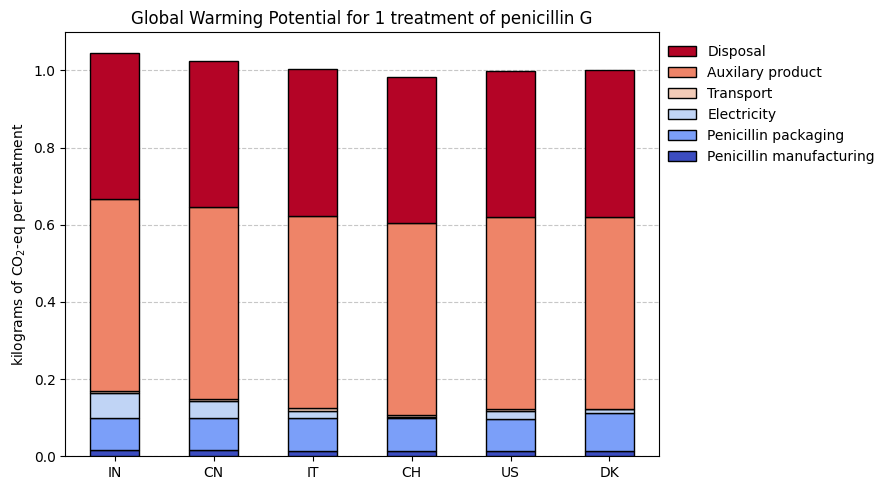

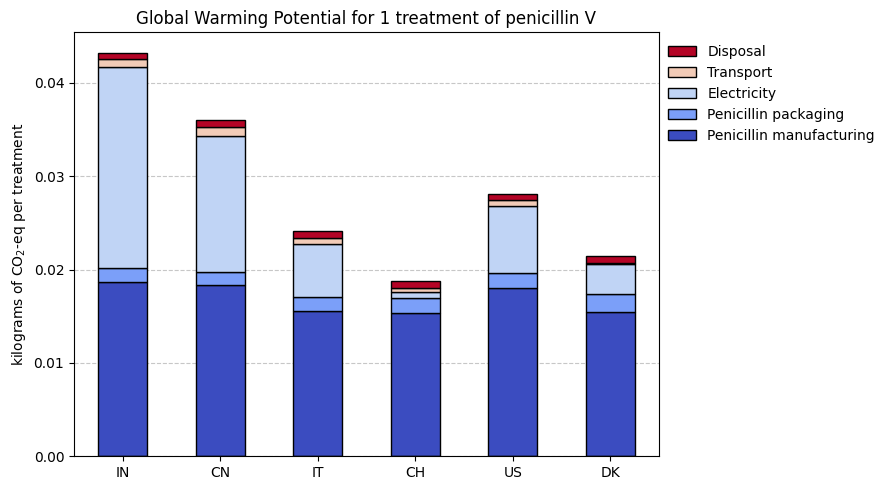

In [ ]:
width = 0.5


for p, (pen, df) in enumerate(df_res_dct.items()):
    colors = s.color_range(colorname="coolwarm", color_quantity=len(df.index))
    fig, ax = plt.subplots(figsize=(9, 5))
    df.T.plot(
        kind='bar',
        stacked=True,
        title=pen,
        color=colors,
        ax=ax,
        width=width,
        edgecolor="k",
        zorder=10
    )

    leg_color, _ = fig.gca().get_legend_handles_labels()
    leg_txt = list(df.index)
    if "V" in pen_type[p]:
        leg_txt.pop(-2)
        leg_color.pop(-2)
        
    # Reverse the order of handles and labels
    leg_txt = leg_txt[::-1]
    leg_color = leg_color[::-1]
    


    ax.legend(
            leg_color,
            leg_txt,
            loc='upper left',
            bbox_to_anchor=(0.995, 1),
            ncol= 1,  # Adactjust the number of columns based on legend size
            fontsize=10,
            frameon=False
        )
    ax.set_title(f"Global Warming Potential for 1 treatment of penicillin {pen_type[p]}")
    ax.set_ylabel('kilograms of CO$_2$-eq per treatment')
    ax.set_xticklabels(xtick_txt, rotation=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=-0)
    plt.tight_layout()
    plt.show()